# Likelihood evaluations for Palanque-Delabrouille et al. (2013)

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import sys
import os
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 120
mpl.rcParams['figure.dpi'] = 120
# our own modules
import simplest_emulator
import linear_emulator
import gp_emulator
import data_PD2013
import mean_flux_model
import thermal_model
import pressure_model
import camb_cosmo
import fit_linP
import likelihood
import lya_theory

### Specify suite of simulations to use, read P1D arxiv and setup simplest emulator

In [3]:
basedir='/Users/font/Projects/LyaCosmoParams/p1d_emulator/sim_suites/emulator_512_15062019'
use_gp=True
undersample_z=1
paramList=["Delta2_p","mF","sigT_Mpc","gamma","kF_Mpc"]
if use_gp:
    emu=gp_emulator.GPEmulator(basedir=basedir,undersample_z=undersample_z,paramList=paramList,train=True)
else:
    emu=linear_emulator.LinearEmulator(basedir=basedir,undersample_z=undersample_z,
                                       drop_tau_rescalings=False,drop_temp_rescalings=False,verbose=False)

Rescaled params to unity volume
Training GP
Optimised


### Read P1D data from Palanque-Delabrouille et al. (2013)

In [4]:
data=data_PD2013.P1D_PD2013(blind_data=False,zmin=2.3,zmax=3.7)
zs=data.z
Nz=len(zs)

### Setup Lyman alpha theory

In [5]:
theory = lya_theory.LyaTheory(zs,emulator=emu,verbose=False)

Note: redshifts have been re-sorted (earliest first)


In [6]:
# emulate P1D for all redshifts
k_kms=data.k
emu_p1d_kms=theory.get_p1d_kms(k_kms=k_kms)

### Compare emulator calls to models in arxiv, for all redhsifts

In [7]:
free_parameters=['ln_tau_0']
like=likelihood.Likelihood(data=data,theory=theory,free_parameters=free_parameters)
like.go_silent()

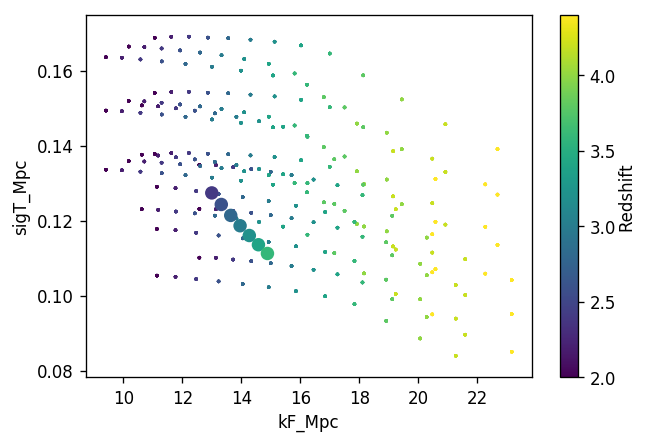

In [8]:
like.overplot_emulator_calls('kF_Mpc','sigT_Mpc')

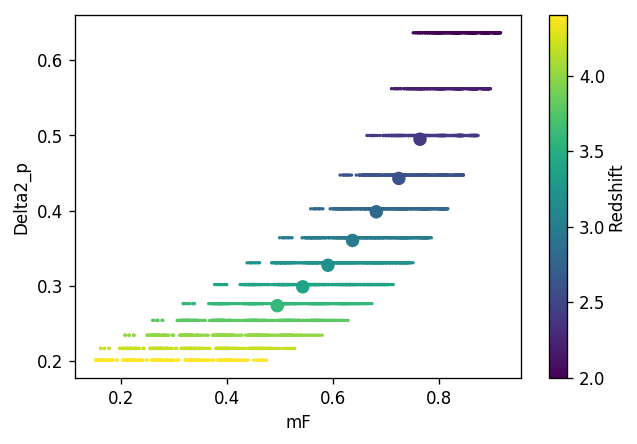

In [9]:
like.overplot_emulator_calls('mF','Delta2_p',tau_scalings=True)

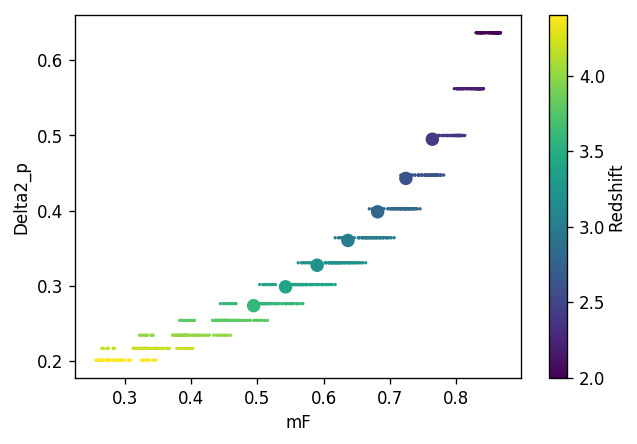

In [10]:
like.overplot_emulator_calls('mF','Delta2_p',tau_scalings=False)

### For each redshift, plot data vs model

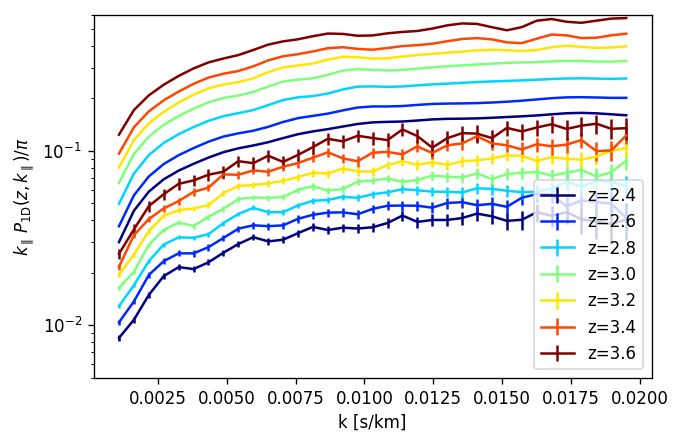

In [17]:
like.plot_p1d(plot_every_iz=1)

In [15]:
# now using Puchwein 2018
basedir_P18='/Users/font/Projects/LyaCosmoParams/p1d_emulator/sim_suites/emulator_512_17052019'
emu_P18=gp_emulator.GPEmulator(basedir=basedir_P18,undersample_z=2,paramList=paramList,train=True)

Rescaled params to unity volume
Training GP
Optimised


In [16]:
theory_P18 = lya_theory.LyaTheory(zs,emulator=emu_P18,verbose=False)
like_P18=likelihood.Likelihood(data=data,theory=theory_P18,free_parameters=free_parameters)
like_P18.go_silent()

Note: redshifts have been re-sorted (earliest first)


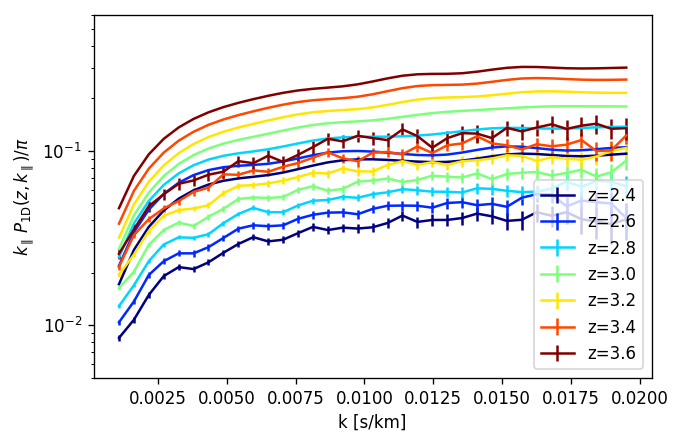

In [18]:
like_P18.plot_p1d(plot_every_iz=1)

### Plot chi2 vs mean optical depth parameter

In [19]:
chi2=like.get_chi2()
print('chi2 =',chi2)

chi2 = 817797.628271


In [20]:
# will explore all range of effective optical depth at z=3
value_in_cube=np.linspace(0.0,1.0,100)
Np=len(value_in_cube)
chi2=np.empty(Np)
tau0=np.empty(Np)
par=like.free_params[0]
for i in range(Np):
    ln_tau_0=par.value_from_cube(value_in_cube[i])
    tau0[i]=np.exp(ln_tau_0)
    chi2[i] =like.get_chi2(values=[value_in_cube[i]])
    #print(i,value_in_cube[i],tau0[i],np.exp(-tau0[i]),'chi2 =',chi2[i])

Text(0, 0.5, '$\\chi^2$')

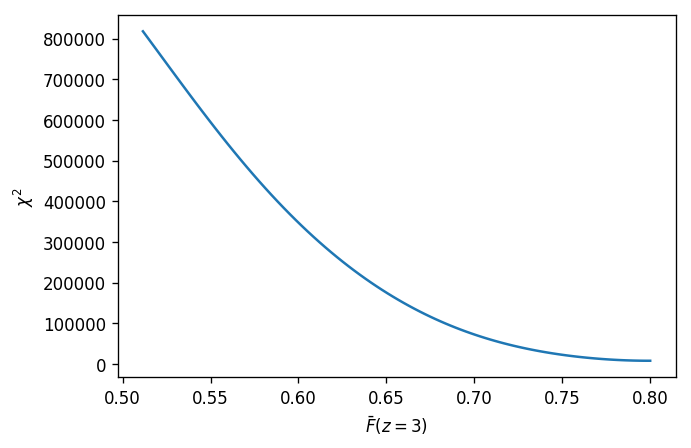

In [21]:
plt.plot(np.exp(-tau0),chi2)
plt.xlabel(r'$\bar F(z=3)$')
plt.ylabel(r'$\chi^2$')